<a href="https://colab.research.google.com/github/babin411/Fusemachine-Internship/blob/main/Projects/Emotion%20Classification/Final_Copy_of_Emotion_Classification_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import files

In [3]:
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv
Saving val.csv to val.csv


In [4]:
from torchtext.legacy import data
import torch
import random

In [5]:
available_device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(available_device)
device

device(type='cuda')

## Creating the dataset and iterator

In [6]:
import spacy

In [7]:
spacy_en = spacy.load('en_core_web_sm')

In [8]:
for token in spacy_en.tokenizer('I had a horrible day.'):
    print(token)

I
had
a
horrible
day
.


In [9]:
def tokenizer(text): #creating a tokenizer function
    '''
        text: takes a sentence as an input
        return: a list of token generated from text
    '''
    return [token.text for token in spacy_en.tokenizer(text)]

In [10]:
tokenizer('I had a horrible day.')

['I', 'had', 'a', 'horrible', 'day', '.']

In [11]:
TEXT = data.Field(tokenize='spacy',
                  tokenizer_language='en_core_web_sm')

LABEL = data.LabelField(dtype=torch.float)

fields = [('TEXT', TEXT), ('LABEL', LABEL)]

In [12]:
train_dataset = data.TabularDataset(path='train.csv', 
                                    format='csv',
                                    fields=fields,
                                    skip_header=True)
print(f'Length of Train Dataset: {len(train_dataset)}')

Length of Train Dataset: 16000


In [13]:
vars(train_dataset.examples[0])

{'LABEL': 'sadness', 'TEXT': ['i', 'did', 'nt', 'feel', 'humiliated']}

In [14]:
validation_dataset = data.TabularDataset(path='val.csv', 
                                    format='csv',
                                    fields=fields,
                                    skip_header=True)
print(f'Length of Validation Dataset: {len(validation_dataset)}')

Length of Validation Dataset: 2000


In [15]:
test_dataset = data.TabularDataset(path='test.csv', 
                                    format='csv',
                                    fields=fields,
                                    skip_header=True)
print(f'Length of Test Dataset: {len(test_dataset)}')

Length of Test Dataset: 2000


Below, we will build a vocabulary using the `Training Set` for a look up table where every unique word in  the `Training Set` has a corresponding index (an integer).

We do this because our deep learning model cannot operate on string, but only on numbers. 

In [16]:
MAX_VOCAB_SIZE = 15000
TEXT.build_vocab(train_dataset, max_size=MAX_VOCAB_SIZE)
LABEL.build_vocab(train_dataset)

print(f'Vocab Size: {len(TEXT.vocab)}')
print(f'Label size: {len(LABEL.vocab)}')

Vocab Size: 15002
Label size: 6


**Note: We build vocabulary from the training set only as for our machine learning model we do not want it to look at the test and validation set in any way.**

When we feed sentences into our model, we feed a batch of them at a time, i.e more than one at a time and all sentences in the batch need to be of the same size. Thus, to ensure each sentence in the batch is the same size, any shorter than the longest within the batch are padded. 

For example:

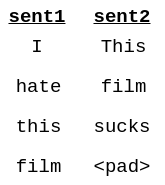

Here, even though we have defined the vocab size to be a maximum of 15000, but we get a  vocab size of 15002 becasue, the $<unk>$ token and the other $<pad>$ token is added to the vocabulary.

We can see what word is associated with each row by checking the `itos` (int to string) list.

Below implies that row 0 is the vector associated with the word $<unk>$, row 1 for $<pad>$, row 2 for 'i', row 3 for 'feel' and so on. 

The token $<unk>$ are used for those words that appear in examples but not in vocabulary. For example, if the sentence was 'This film is great and I love it' but the word **"love"** was not in the vocabulary, then it would become "This film is great and I $<unk>$ it."

In [17]:
TEXT.vocab.itos[:10]

['<unk>', '<pad>', 'i', 'feel', 'and', 'to', 'the', 'a', 'that', 'feeling']

In [18]:
LABEL.vocab.freqs

Counter({'anger': 2159,
         'fear': 1937,
         'joy': 5362,
         'love': 1304,
         'sadness': 4666,
         'surprise': 572})

In [19]:
top_20_common_words = TEXT.vocab.freqs.most_common(20)
top_20_common_words

[('i', 29007),
 ('feel', 11183),
 ('and', 9589),
 ('to', 8972),
 ('the', 8370),
 ('a', 6201),
 ('that', 5217),
 ('feeling', 5112),
 ('of', 4990),
 ('my', 4283),
 ('in', 3433),
 ('it', 3133),
 ('like', 2908),
 ('m', 2876),
 ('so', 2527),
 ('for', 2431),
 ('was', 2322),
 ('me', 2309),
 ('have', 2298),
 ('but', 2255)]

### Creating the iterator

The final step of preparing the data is creating the iterators. We iterate over these in the training/evaluation loop, and they return a batch of examples (indexed and converted into tensors) at each iteration. 

We will use a `torchtext.data.BucketIterator` which is a special type of iterator that will return a batch of examples where each example is of a similar length, minimizing the amount of padding per example.

We will also want to place the tensors returned by the iterator on the GPU. PyTorch handles this using `torch.device`, we then pass this device to the iterator.

In [20]:
BATCH_SIZE = 64

train_iterator, val_iterator, test_iterator = data.BucketIterator.splits(
                                              (train_dataset, validation_dataset, test_dataset),
                                              batch_size=BATCH_SIZE,
                                              sort_within_batch=False,          #
                                              sort_key=lambda x: len(x.TEXT), # 
                                              device=device)

In [21]:
print('Train')
for batch in train_iterator:
    print(batch.TEXT.size())
    print(batch.LABEL.size())
    break
print('\n')
print('Validation: ')
for batch in val_iterator:
    print(batch.TEXT.size())
    print(batch.LABEL.size())
    break
print('\n')
print('Test:')
for batch in test_iterator:
    print(batch.TEXT.size())
    print(batch.LABEL.size())
    break


Train
torch.Size([43, 64])
torch.Size([64])


Validation: 
torch.Size([5, 64])
torch.Size([64])


Test:
torch.Size([5, 64])
torch.Size([64])


### Defining the Model

For building a LSTM model, we use a sub-class of `nn.Module` and the use of `super`.

Within the `__init__` we define the layers for our LSTM module. Out three layers are an embedding layer, our LSTM layer and a linear layer. All layers have their parameters initialized to random values, unless explicitely specified. 

The embedding layer is used to transform our `sparse one-hot-vector` (sparse as most of the elements are 0) into a dense embedding vector (dense as the dimensionality is a lot smaller and all the elements are real numbers). This embedding layer is simply a single fully connected layer. As well as reducing the dimensionality of the input to the LSTM, there is the theory that words which have similar impact on the sentiment of the review are mapped closed together in this dense vector space. 

In [22]:
from torch import nn

In [23]:
class EmotionClassificationModel(nn.Module):
    def __init__(self,no_layers, input_dim, embedding_dim, hidden_dim, num_classes =6):
        super(EmotionClassificationModel, self).__init__()
        self.hidden_dim=hidden_dim
        self.no_layers = no_layers
        self.input_dim = input_dim

        
        # embedding andn LSTM layers
        # embedding
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        
        #lstm
        self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size= self.hidden_dim,
                            num_layers = no_layers)

        
        #dropout layer
        self.dropout = nn.Dropout(0.3)

        #linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, num_classes)




    def forward(self,x):
        # x = [sentence length, batch size]

        # embeddings and lstm_out
        embeddings = self.embedding(x)
        #embedded dim: [sentence length, batch_size, embedding dim]

        # Set initial hidden and cell states
        # h0 = torch.zeros((self.no_layers, BATCH_SIZE, self.hidden_dim)).to(device)
        # c0 = torch.zeros((self.no_layers, BATCH_SIZE, self.hidden_dim)).to(device)
        
        # print('\n')
        # print(f'Size of Embedding Layer Output: {embeddings.size()}')

        lstm_output, (hidden,cell) = self.lstm(embeddings)
        
        # lstm_output dim: [sentence length, batch size, hidden dim]
        # hidden dim: [1, batch size, hidden dim]

        # print('\n')
        # print(f'Size of LSTM Output: {lstm_output.size()}')

        #dropout and fully connected layer
        hidden = hidden[-1]
        hidden = self.dropout(hidden)

        
        # # sigmoid function
        # sig_out = self.sig(out)
        
        # # reshape to be batch_size first
        # sig_out = sig_out.view(batch_size, -1)

        # sig_out = sig_out[:, -1] # get last batch of labels

        # output= self.fc(output[-1,:,:])
        predictions = self.fc(hidden)
        
        # output = nn.Softmax(output)

        # print(f'Size of FC Ouput: {output.size()}')

        return predictions


    # def init_hidden(self, batch_size=64):
    #     '''Initializes hidden state'''
    #     #Create two new tensors with sizes n_layers x batch_size x hidden_dim,
    #     #Initialized to zero, for hidden state and cell state of LSTM
    #     h0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)
    #     c0 = torch.zeros((self.no_layers, batch_size, self.hidden_dim)).to(device)

    #     hidden = (h0,c0)
    #     return hidden

### Initialize the model

In [24]:
NO_LAYERS  = 2
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 6

model = EmotionClassificationModel(NO_LAYERS, INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM)
model.to(device)

EmotionClassificationModel(
  (embedding): Embedding(15002, 128)
  (lstm): LSTM(128, 256, num_layers=2)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=6, bias=True)
)

In [25]:
!pip install torchinfo

In [26]:
from torchinfo import summary

In [27]:
summary(model)

Layer (type:depth-idx)                   Param #
EmotionClassificationModel               --
├─Embedding: 1-1                         1,920,256
├─LSTM: 1-2                              921,600
├─Dropout: 1-3                           --
├─Linear: 1-4                            1,542
Total params: 2,843,398
Trainable params: 2,843,398
Non-trainable params: 0

### Define Optimizer and Criterion

In [28]:
from torch.optim import Adam

lr = 0.001
optimizer = Adam(model.parameters(), lr=lr)

#Below we'll define a loss function. We will use a categorical cross entorpy
criterion = nn.CrossEntropyLoss()

### Accuracy Measuring Function

In [29]:
def batch_accuracy(preds, y):
    rounded_preds = torch.round(torch.nn.functional.softmax(preds))
    _, pred_idx = rounded_preds.max(1)
    correct = (pred_idx==y).float() 
    acc = correct.sum() / len(y)
    return acc

### Evaluating Function

In [30]:
def evaluate(model, iterator, criterion):
    total_loss = 0
    total_accuracy = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            out = model(batch.TEXT.to(device))
            scores = out.squeeze(1)

            loss = criterion(scores, batch.LABEL.type(torch.LongTensor).to(device))
            accuracy = batch_accuracy(scores, batch.LABEL)

            total_accuracy+=accuracy.item()
            total_loss+=loss.item()

    return total_loss/len(iterator), total_accuracy/len(iterator)

### Training Loop

In [31]:
len(train_iterator)

250

In [32]:
from tqdm import tqdm

In [33]:
NUM_EPOCHS=15
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_iterator,
                total=len(train_iterator),
                leave=True)
    
    model.train()
    for batch in loop:
        x = batch.TEXT.to(device)
        y = batch.LABEL.type(torch.LongTensor).to(device)
        
        #Forward Pass
        out = model(x)
        loss = criterion(out, y)

        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()

        #Propagating the error backward
        loss.backward()

        #Optimizing the parameters
        optimizer.step()

        count+=1

        train_acc = batch_accuracy(out, batch.LABEL)

        #appedning to list
        if count%100==0:
            loss_list.append(loss.item())
            accuracy_list.append(train_acc.item())
            iteration_list.append(count)

        # Setting loop descriptions
        loop.set_description(f'Epoch [{epoch+1}/{NUM_EPOCHS}]')
        loop.set_postfix(loss=loss.item(), train_acc = train_acc.item())
        
    # val_loss, val_acc = evaluate(model, val_iterator, criterion)
    # loop.set_postfix(loss=loss.item(), train_acc=train_acc.item(), val_loss = val_loss, val_acc=val_acc)
        
print(f'Done Training')

  0%|          | 0/250 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
Epoch [15/15]: 100%|██████████| 250/250 [00:09<00:00, 26.91it/s, loss=0.0162, train_acc=1]

Done Training


In [34]:
len(loss_list), len(accuracy_list), len(iteration_list)

(37, 37, 37)

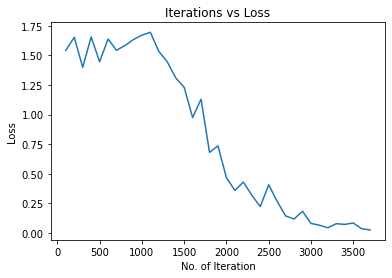

In [35]:
plt.plot(iteration_list, loss_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Loss")
plt.title("Iterations vs Loss")
plt.show()

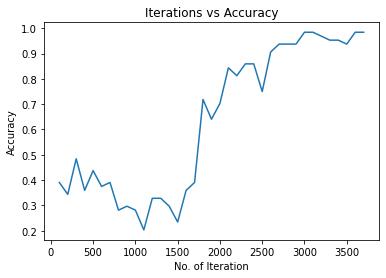

In [36]:
plt.plot(iteration_list, accuracy_list)
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Iterations vs Accuracy")
plt.show()

In [37]:
val_loss, val_acc = evaluate(model, val_iterator, criterion)
print(f'Validation Loss: {val_loss:.3f} | Validation Accuracy: {val_acc*100:.2f}')

Validation Loss: 0.457 | Validation Accuracy: 87.01


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


In [38]:
test_loss, test_acc = evaluate(model, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  


Test Loss: 0.510 | Test Acc: 86.23%


### Generate Resutls


In [39]:
def predict_sentiment(model, review):
    model.eval()
    tokens = tokenizer(review)
    indexed = [TEXT.vocab.stoi[t] for t in tokens]
#     length = [len(indexed)]    
    in_tensor = torch.LongTensor(indexed).to(device)
    in_tensor = in_tensor.unsqueeze(1)
#     length_tensor = torch.LongTensor(le)
    pred = torch.nn.functional.softmax(model(in_tensor),dim=1)
    _, max_idx = pred.max(1)
    return max_idx.item()

In [40]:
LABEL.vocab.itos

['joy', 'sadness', 'anger', 'fear', 'love', 'surprise']

In [41]:
result_idx = predict_sentiment(model, 'i hate NLP so much. it makes me furious. never going to study this shit again.')
LABEL.vocab.itos[result_idx]

'anger'

In [42]:
LABEL.vocab.stoi

defaultdict(None,
            {'anger': 2,
             'fear': 3,
             'joy': 0,
             'love': 4,
             'sadness': 1,
             'surprise': 5})

In [43]:
vars(test_dataset.examples[0])

{'LABEL': 'sadness',
 'TEXT': ['i',
  'm',
  'feeling',
  'rather',
  'rotten',
  'so',
  'i',
  'm',
  'not',
  'very',
  'ambitious',
  'right',
  'now']}

In [44]:
result_idx = predict_sentiment(model, 'I am feeling rather rotten so i am not very ambitious right now')
LABEL.vocab.itos[result_idx]

'sadness'

In [45]:
result_idx = predict_sentiment(model, 'i will practice meditation if i feel overwhelmed and hopefully become successful in peaceful practice')
LABEL.vocab.itos[result_idx]

'surprise'

In [46]:
result_idx = predict_sentiment(model, 'i explain why i clung to a relationship with a boy who was in many ways immature and uncommitted despite the excitement i should have been feeling for getting accepted into the masters program at the university of virginia')
LABEL.vocab.itos[result_idx]

'joy'

In [47]:
result_idx = predict_sentiment(model, 'im enjoying my solitary confinement at home i rarely feel lonely')
LABEL.vocab.itos[result_idx]

'sadness'

### Gradio Implementation

In [48]:
!pip install gradio

     |████████████████████████████████| 659 kB 4.0 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
     |████████████████████████████████| 255 kB 43.4 MB/s 
     |████████████████████████████████| 211 kB 36.1 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 1.1 MB 42.1 MB/s 
     |████████████████████████████████| 84 kB 2.1 MB/s 
     |████████████████████████████████| 2.0 MB 33.9 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 144 kB 35.4 MB/s 
     |████████████████████████████████| 271 kB 38.0 MB/s 
     |████████████████████████████████| 10.9 MB 19.8 MB/s 
     |████████████████████████████████| 58 kB 4.9 MB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 3.6 MB 18.6 MB/s 
     |████████████████████████████████| 856 kB 15.5 MB/s 
     |██████████████████████

In [49]:
import gradio as gr

In [50]:
import numpy as np

In [51]:
vars(test_dataset.examples[0])

{'LABEL': 'sadness',
 'TEXT': ['i',
  'm',
  'feeling',
  'rather',
  'rotten',
  'so',
  'i',
  'm',
  'not',
  'very',
  'ambitious',
  'right',
  'now']}

In [52]:
vars(test_dataset.examples[np.random.randint(0, len(test_dataset))])['TEXT']

['i', 'really', 'do', 'feel', 'superior']

In [53]:
def get_random_text(test_dataset):
    random_number = np.random.randint(0, len(test_dataset))
    sentence_token = vars(test_dataset.examples[random_number])['TEXT']
    label = vars(test_dataset.examples[random_number])['LABEL']
    sentence = ' '.join(sentence_token) 
    return label, sentence

In [54]:
label, sentence = get_random_text(test_dataset)
print(f'LABEL: {label}\n SENTENCE: {sentence}')

LABEL: love
 SENTENCE: i love rides but was nt feeling too hot this day


In [55]:
from difflib import Differ

import gradio as gr


def make_prediction(text):
    tokens = tokenizer(text)
    index = [TEXT.vocab.stoi[t] for t in tokens]
    in_tensor=torch.LongTensor(index).to(device)
    in_tensor = in_tensor.unsqueeze(1)
    pred =torch.nn.functional.softmax(model(in_tensor), dim=1)
    _, max_idx = pred.max(1)
    emotion = LABEL.vocab.itos[max_idx.item()]
    return emotion

iface = gr.Interface(
    make_prediction,
    [
        gr.inputs.Textbox(
            lines=3, default='Enter your text here.'
        ),
    ],
    outputs = 'text'
)
iface.launch()


Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://18629.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<fastapi.applications.FastAPI at 0x7f987b4d0710>,
 'http://127.0.0.1:7860/',
 'https://18629.gradio.app')